# Automatic Annotation of Environmental Sentences

## 1. Introduction

### 1.1 Background and Purpose

This notebook applies a rule-based method to annotate environmental text with named entities. It is the third stage in a pipeline for building a domain-specific Named Entity Recognition (NER) dataset. Earlier stages involved sentence segmentation and vocabulary construction.

The goal here is to automatically assign entity labels to pre-segmented sentences using curated vocabulary lists. Each vocabulary term is matched directly in text, and the matching span is annotated with its corresponding category. This produces a labelled dataset that can be used to train NER models.

The method prioritises speed, scale, and reproducibility. It requires no manual annotation or machine learning during this stage.

### 1.2 Objectives

The main objectives of this notebook are:

- Apply each vocabulary category (TAXONOMY, HABITAT, ENV_PROCESS, POLLUTANT, MEASUREMENT) to a large sentence corpus
- Construct an Aho-Corasick trie per category for efficient multi-pattern matching
- Handle overlapping and nested matches through precedence and merging rules
- Apply custom logic for MEASUREMENT entities, ensuring numbers and units are annotated together
- Generate output in a SpaCy-compatible .jsonl format for model training
- Validate annotations using programmatic checks and spot-checking of random samples

### 1.3 Challenges in Rule-Based Annotation

Rule-based annotation offers simplicity and transparency but presents several challenges that must be addressed carefully:

**Overlapping entities across categories**  
Certain terms may appear in multiple categories or as part of longer expressions. For example, the word "forest" may be listed as a HABITAT but also occur in the species name "African forest elephant" (TAXONOMY). Overlapping matches must be resolved by choosing the longest span or prioritising specific categories.

**Lack of context awareness**  
Exact term matching does not account for semantic context. This can result in false positives where a term has different meanings (e.g. “Amazon” referring to a company vs. a rainforest).

**Span boundaries and formatting**  
Care must be taken to ensure that only the correct characters are included in each entity span. Matches must be aligned to full words and should not include punctuation, whitespace, or extraneous tokens.

**Special treatment for measurement expressions**  
Measurement entities such as “20 kg” or “<10 µg/L” require combined annotation of numbers and units. These must be identified and merged into single spans even when not contiguous in the vocabulary list.

**Vocabulary coverage and noise**  
Some terms may not be present in the vocabulary and will be missed. Others may be too generic and match unintended text. This stage must balance recall with precision and include mechanisms for iterative refinement of the vocab lists.

## 2. Method Overview

### 2.1 What Is Aho-Corasick Matching?
The Aho-Corasick algorithm is a fast and efficient method for matching many string patterns at once. It builds a data structure called a trie, which allows it to search for all vocabulary terms in a sentence in a single pass.

This makes it well-suited for Named Entity Recognition tasks where the goal is to find known phrases (e.g. "climate change", "acid rain") across a large body of text. Unlike regular expressions or repeated substring searches, Aho-Corasick performs in linear time with respect to the input length.

In this notebook, one Aho-Corasick matcher is created for each entity category (e.g. TAXONOMY, HABITAT). Each match includes the matched text, its character span, and its associated category label.

### 2.2 Why Weak Labelling?
Weak labelling refers to the automatic assignment of labels using predefined rules or resources, rather than manual annotation. In this case, the labels are derived from vocabulary lists matched against the text.

This approach is commonly used when:
- Manual annotation is too costly or time-consuming
- Domain expertise is required to label data accurately
- A large amount of unlabelled text is available

Weak labelling allows researchers to generate useful training data without human effort, using only heuristics or dictionaries. It is particularly effective in structured domains like environmental science, where many terms are standardised.

### 2.3 Benefits and Limitations
#### Benefits:
- Fast and scalable to large corpora
- Easy to understand and reproduce
- High recall for known vocabulary terms
- Suitable for domains with well-defined terminology

#### Limitations:
- No understanding of context or meaning
- Fails to detect entities not in the vocabulary
- Can produce false positives (e.g. "Amazon" as rainforest vs company)
- Requires careful span handling to avoid overlap or misalignment

This method is not a replacement for human-labelled data, but it provides a strong starting point. The resulting annotations can be used to train statistical models or refine vocabularies through iteration and validation.

## 3. Annotation Process
In this section, the annotation process is initialised using the Aho-Corasick algorithm for each entity category. A case-insensitive matcher is built for every vocabulary, and core matching functionality is defined to identify valid entity spans within each sentence. This enables efficient detection of known terms while filtering out partial or incorrect matches.

In [44]:
import os
import json
import time
from pathlib import Path
from collections import defaultdict

import ahocorasick

SEGMENTED_PATH = Path("../data/segmented_text")
VOCAB_PATH = Path("../vocabs/final")
OUTPUT_PATH = Path("../data/json")
os.makedirs(OUTPUT_PATH, exist_ok=True)

### 3.1 Load all sentences
All pre-segmented sentences are loaded from the corpus folder. This creates a single list containing every sentence to be annotated.

In [45]:
all_sentences = []

for file_path in SEGMENTED_PATH.rglob("*.txt"):
    with open(file_path, encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]
        all_sentences.extend(lines)

print(f"Loaded {len(all_sentences):,} sentences")

Loaded 2,748,655 sentences


The total number of sentences is 2,748,655. Only those containing at least one matched entity will be retained in the final dataset.

### 3.2 Load vocabulary and build automata
Each vocabulary file is read and converted into an Aho-Corasick automaton for fast multi-pattern matching. One matcher is created per entity category.

In [46]:
matchers = {}

for vocab_file in VOCAB_PATH.glob("*.txt"):
    label = vocab_file.stem.upper()

    with open(vocab_file, encoding="utf-8") as f:
        terms = [line.strip().lower() for line in f if line.strip()]
    
    automaton = ahocorasick.Automaton()
    for term in terms:
        automaton.add_word(term, (term, label))
    automaton.make_automaton()

    matchers[label] = automaton
    print(f"Loaded {len(terms):,} terms for {label}")

Loaded 1,250 terms for POLLUTANT
Loaded 1,303 terms for ENV_PROCESS
Loaded 1,170 terms for MEASUREMENT
Loaded 574 terms for HABITAT
Loaded 129,452 terms for TAXONOMY


This step loads over 130,000 taxonomy terms and around 500–1,300 terms for each of the other four categories. These matchers will be used to scan each sentence for known entity terms

### 3.3 Define span-matching logic
This step defines the core function used to detect vocabulary matches within a sentence. Matches are returned as character spans only if they respect full-word boundaries and are not part of hyphenated words. This helps avoid partial or incorrect matches (e.g. skipping "rain" in "acid-rainfall").

In [47]:
def is_inside_hyphenated_word(text: str, start: int, end: int) -> bool:
    """True if the span touches a hyphen that is part of a larger word"""
    return (start > 0 and text[start-1] == '-') or (end < len(text) and text[end] == '-')


def annotate_text_with_vocab(text: str, automaton, label: str):
    """Return a list of [start, end, label] spans matched in input text"""
    lowered = text.lower()
    text_len = len(text)
    spans = []

    for end_idx, (term, _) in automaton.iter(lowered):
        start_idx = end_idx - len(term) + 1

        before_ok = start_idx == 0 or not text[start_idx-1].isalnum()
        after_ok  = end_idx + 1 == text_len or not text[end_idx+1].isalnum()

        if before_ok and after_ok and not is_inside_hyphenated_word(text, start_idx, end_idx+1):
            spans.append([start_idx, end_idx+1, label])

    spans.sort(key=lambda s: (s[0], s[1]-s[0]))
    return spans

### 3.4 Annotating the data
Each sentence is passed through all five Aho-Corasick matchers. Matching spans are stored per sentence if they meet the boundary rules defined earlier. Sentences without any entity match are ignored at this stage.

This approach is fast and scalable. However, it produces weak labels since matches are based only on exact vocabulary terms, without any use of surrounding context.

In [48]:
raw_annotations = defaultdict(list)

for i, sentence in enumerate(all_sentences):
    for label, automaton in matchers.items():
        matches = annotate_text_with_vocab(sentence, automaton, label)
        if matches:
            raw_annotations[sentence].extend(matches)

    if (i + 1) % 100000 == 0:
        print(f"Annotated {i + 1:,}/{len(all_sentences):,} sentences")

print(f"Annotated {len(raw_annotations):,} sentences with at least one entity")

Annotated 100,000/2,748,655 sentences
Annotated 200,000/2,748,655 sentences
Annotated 300,000/2,748,655 sentences
Annotated 400,000/2,748,655 sentences
Annotated 500,000/2,748,655 sentences
Annotated 600,000/2,748,655 sentences
Annotated 700,000/2,748,655 sentences
Annotated 800,000/2,748,655 sentences
Annotated 900,000/2,748,655 sentences
Annotated 1,000,000/2,748,655 sentences
Annotated 1,100,000/2,748,655 sentences
Annotated 1,200,000/2,748,655 sentences
Annotated 1,300,000/2,748,655 sentences
Annotated 1,400,000/2,748,655 sentences
Annotated 1,500,000/2,748,655 sentences
Annotated 1,600,000/2,748,655 sentences
Annotated 1,700,000/2,748,655 sentences
Annotated 1,800,000/2,748,655 sentences
Annotated 1,900,000/2,748,655 sentences
Annotated 2,000,000/2,748,655 sentences
Annotated 2,100,000/2,748,655 sentences
Annotated 2,200,000/2,748,655 sentences
Annotated 2,300,000/2,748,655 sentences
Annotated 2,400,000/2,748,655 sentences
Annotated 2,500,000/2,748,655 sentences
Annotated 2,600,00

This step annotated 735,542 out of 2,748,655 sentences, meaning around 2 million sentences were excluded due to no matches.

This is a normal outcome in weak labelling. Removing unmatched sentences improves overall label precision by avoiding empty or noisy examples.

### 3.5 removing overlaping spans
Some sentences contain overlapping entity matches. These occur when multiple vocabulary terms match substrings that share characters. For example, both “salt” and “salt marsh” may appear in the same span.

In such cases, only the longest span is retained. This helps preserve contextual clarity and reduces noise from nested or partial terms.

The following code checks the annotated data for overlaps and prints a few examples for inspection.

In [49]:
def has_overlap(spans):
    spans = sorted(spans, key=lambda x: x[0])
    for i in range(len(spans)-1):
        if spans[i][1] > spans[i+1][0]:
            return True
    return False

print("\nSentences with overlapping entity spans:\n")
count = 0
for sent, spans in raw_annotations.items():
    if has_overlap(spans):
        print(f"Sentence: {sent}")
        print(f"Spans: {spans}\n")
        count += 1
        if count == 5:
            break

if count == 0:
    print("No overlapping spans found.")


Sentences with overlapping entity spans:

Sentence: During sediment collection samplers were removed from the metal uprights secured to the river bed and the contents emptied into 5-L containers.
Spans: [[88, 93, 'HABITAT'], [88, 97, 'HABITAT']]

Sentence: All samples were lightly hand ground, pressed and then measured under a He atmosphere under combined Pd and Co excitation radiation and using a high resolution, low spectral interference silicon drift detector.
Spans: [[122, 131, 'POLLUTANT'], [122, 131, 'POLLUTANT']]

Sentence: Results are the average of three repeats after elimination of outliers, a process that minimises intra-sample noise in the laser granulometry.
Spans: [[110, 115, 'POLLUTANT'], [110, 115, 'POLLUTANT']]

Sentence: Earth Surface Processes and Landforms 26: 1237 1248.
Spans: [[28, 37, 'HABITAT'], [28, 37, 'HABITAT']]

Sentence: Springer; 373 390 Folk RL, Ward WC. 1957.
Spans: [[0, 8, 'TAXONOMY'], [0, 8, 'TAXONOMY']]



To ensure annotation consistency, overlapping spans must be removed. When two or more entity matches share characters, the longest match is retained. This reduces ambiguity and helps maintain clean training data.

The function below implements a “longest-match-wins” strategy by sorting spans by start position and length, and then keeping only non-overlapping ones. Exact duplicate spans are also removed beforehand.

In [50]:
def resolve_overlaps(spans):
    """Keep longest span when overlaps occur"""
    spans = sorted(spans, key=lambda s: (s[0], -(s[1]-s[0])))
    resolved, occupied = [], set()
    for s, e, lbl in spans:
        if not any(pos in occupied for pos in range(s, e)):
            resolved.append([s, e, lbl])
            occupied.update(range(s, e))
    return resolved

In [51]:
clean_annotations = {}

for sent, spans in raw_annotations.items():
    deduped = list({(s, e, l) for s, e, l in spans})  # remove exact duplicates
    resolved = resolve_overlaps(deduped)
    if resolved:
        clean_annotations[sent] = resolved

print(f"Cleaned annotations for {len(clean_annotations):,} sentences")

Cleaned annotations for 735,542 sentences


In [52]:
overlap_count = 0
for spans in clean_annotations.values():
    if has_overlap(spans):
        overlap_count += 1

print(f"Sentences with overlapping spans after resolution: {overlap_count}")

Sentences with overlapping spans after resolution: 0


The overlap resolution process cleaned the annotations for 735,542 sentences. A final validation shows that 0 sentences contain overlapping spans, confirming the success of the procedure.

### 3.6 Spot-checking samples
To qualitatively inspect the annotation quality, a small random sample of annotated sentences is printed below. Entities are marked inline in the format [text|LABEL] for readability.

This step helps verify that entity boundaries are accurate and that labels align with expectations. It also highlights whether multi-word terms are correctly captured and whether irrelevant matches are slipping through.

In [53]:
import random

def mark_entities(text, spans):
    spans = sorted(spans, key=lambda x: x[0])
    marked = ""
    last = 0
    for start, end, label in spans:
        marked += text[last:start]
        marked += f"[{text[start:end]}|{label}]"
        last = end
    marked += text[last:]
    return marked

samples = random.sample(list(clean_annotations.items()), 5)

for sent, spans in samples:
    print(mark_entities(sent, spans))
    print()

He has also spread [red squirrels|TAXONOMY] across the Highlands and established [goldeneye|TAXONOMY] [ducks|TAXONOMY] as a breeding species.

In 2022, a unit of the CDC reported that out of 2,310 [urine|POLLUTANT] samples collected, more than 80% were laced with detectable traces of [glyphosate|POLLUTANT].

Marine [protected areas|HABITAT] ([MPAs|MEASUREMENT]) require ecologically meaningful designs capable of taking into account the particularities of the species under consideration, the dynamic nature of the [marine environment|HABITAT], and the multiplicity of [anthropogenic|ENV_PROCESS] impacts.

'War on plastic' could strand oil industry's £300bn investment | Major oil firms plan to grow plastic supply to counter impact of shift against fossil fuels | The war on plastic waste could scupper the oil industry’s multi-billion dollar bet that the world will continue to need more fossil fuels to help make the petrochemicals used in [plastics|POLLUTANT], according to a new report.

Coun

The printed examples demonstrate that the annotation logic performs well:

- Multi-word entities such as "protected areas", "marine environment", and "red squirrels" are correctly labelled.
- Category assignments appear contextually appropriate. For instance, "glyphosate" is labelled as POLLUTANT, while "nuthatches" and "goldeneye ducks" are labelled as TAXONOMY.
- Nested and adjacent entities are cleanly separated, with no sign of overlap or misaligned spans.

Overall, the spot checks indicate that the annotation pipeline is producing high-quality weak labels suitable for model training.

### 3.7 Save annotated data to JSONL
The final cleaned annotations are written to a .jsonl file in SpaCy-compatible format. Each line contains a dictionary with the sentence text and a list of entity spans.

This format will be used for training a NER model in later stages.

In [54]:
jsonl_path = OUTPUT_PATH / "training_data.jsonl"
with jsonl_path.open("w", encoding="utf-8") as f:
    for sent, spans in clean_annotations.items():
        json.dump({"text": sent, "label": spans}, f, ensure_ascii=False)
        f.write("\n")

print(f"\nSaved → {jsonl_path}  ({len(clean_annotations):,} lines)")


Saved → ../data/json/training_data.jsonl  (735,542 lines)


## 4. Analysing Annotated Entities
This section runs basic checks to better understand the output of the rule-based annotation. It includes simple counts and summaries that help validate entity coverage across categories.

The aim is to identify whether any categories dominate or are underrepresented, and to check that the vocabulary terms are being used as expected. These diagnostics provide a useful baseline before moving on to model training or further data refinement.

### 4.1 Entity Counts by Category
This section calculates the total number of entities annotated for each vocabulary category. It provides a high-level overview of entity distribution across the dataset.

In [55]:
from collections import Counter

label_counter = Counter()

for spans in clean_annotations.values():
    for _, _, lbl in spans:
        label_counter[lbl] += 1

print("Entity counts by category\n")
for lbl, n in label_counter.most_common():
    print(f"{lbl:<15} : {n:,}")

Entity counts by category

HABITAT         : 373,060
ENV_PROCESS     : 365,599
TAXONOMY        : 258,948
MEASUREMENT     : 111,187
POLLUTANT       : 96,938


HABITAT and ENV_PROCESS entities are the most frequently matched categories, each with over 350,000 annotations. This reflects the relatively high coverage and generality of terms in these vocabularies. TAXONOMY is also well represented, though lower in volume due to the more specific nature of species and organism names. MEASUREMENT and POLLUTANT categories are less frequent, likely due to narrower term lists and stricter matching criteria (e.g. for units and numerical formats). This distribution may influence model performance and suggests potential areas for further vocabulary expansion.

### 4.2 Most Frequent Entities by Category
This section prints the 30 most frequently matched entities for each vocabulary category. This helps to understand which terms are most dominant in the dataset and whether they align with expectations. It also highlights common patterns, imbalances, or potential sources of noise across different entity types.

In [56]:
from collections import Counter

# Top 30 frequent entity texts per label (lowercased)
for lbl in label_counter:
    c = Counter(
        text[start:end].lower()
        for text, spans in clean_annotations.items()
        for start, end, l in spans
        if l == lbl
    )
    print(f"\n── {lbl} ──")
    for token, n in c.most_common(30):
        print(f"{token:<30} {n}")


── HABITAT ──
habitat                        32782
forest                         25871
ecosystem                      21801
habitats                       21766
river                          20572
ecosystems                     14783
landscape                      12460
forests                        9274
lake                           8154
island                         8084
rivers                         7568
coast                          7220
wood                           6070
grassland                      5635
islands                        4730
landscapes                     4280
wetland                        4225
garden                         4171
reef                           4166
wetlands                       4118
lakes                          3976
bay                            3952
beach                          3886
valley                         3793
national park                  3591
mountain                       3502
hill                           2882
territ

The most common entities reflect both vocabulary design and the nature of environmental text:

- HABITAT is dominated by general ecological terms such as habitat, forest, ecosystem, and river. This shows strong representation of common landscape features.
- MEASUREMENT includes units (mg, kg, km) and environmental indicators (temperature, pH, salinity). These often appear alongside quantitative observations.
- POLLUTANT terms like wastewater, sewage, noise, methane, and carbon dioxide reflect typical environmental hazards. Some highly specific chemicals (pb, arsenic, pcbs) are also well represented.
- TAXONOMY covers high-level terms like fish, birds, and bacteria, as well as species and common animals (whale, salmon, pig). A few odd entries like rocky or ant may require review.
- ENV_PROCESS is led by climate, climate change, and drought. These results confirm that this category captures broader environmental phenomena and stressors.

The data confirms that entity matching works reliably for frequent, well-represented terms. It may also highlight vocabulary areas to refine or extend in future iterations.

### 4.3 Entity Distribution per Sentence
This section examines how many entities appear in each annotated sentence. Understanding this distribution helps assess the density of entity labels across the dataset.

Sentences with very few entities may provide limited training signal, while those with many entities might overwhelm a model or indicate noisy matches. A balanced distribution is generally preferable, especially for training Named Entity Recognition systems.

The analysis includes summary statistics and a histogram to visualise the number of entities per sentence.

Total annotated sentences     : 735,542
Average entities per sentence : 1.64
Max entities in a sentence    : 53
Sentences with only 1 entity  : 449,228
Sentences with >10 entities   : 441


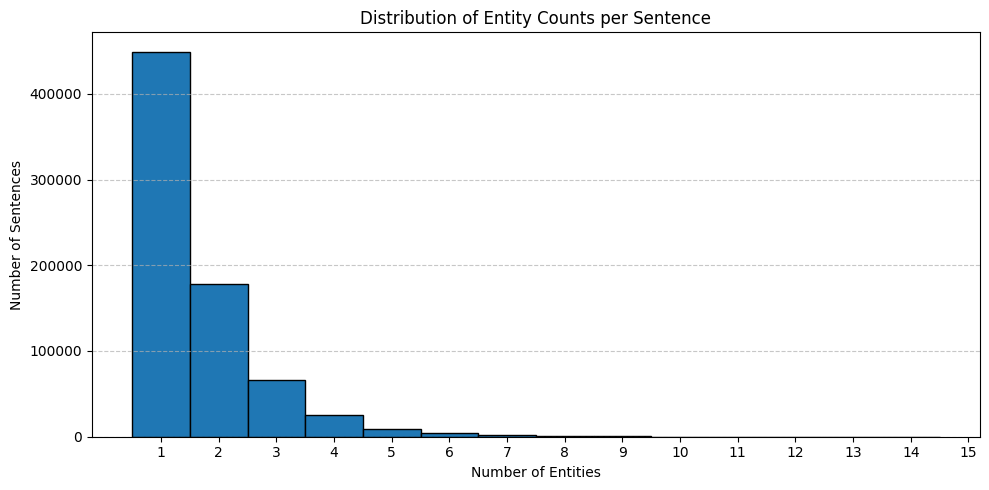

In [57]:
import matplotlib.pyplot as plt

entity_counts = [len(spans) for spans in clean_annotations.values()]

print(f"Total annotated sentences     : {len(entity_counts):,}")
print(f"Average entities per sentence : {sum(entity_counts)/len(entity_counts):.2f}")
print(f"Max entities in a sentence    : {max(entity_counts)}")
print(f"Sentences with only 1 entity  : {(entity_counts.count(1)):,}")
print(f"Sentences with >10 entities   : {sum(1 for c in entity_counts if c > 10):,}")

plt.figure(figsize=(10, 5))
plt.hist(entity_counts, bins=range(1, 16), edgecolor='black', align='left')
plt.title("Distribution of Entity Counts per Sentence")
plt.xlabel("Number of Entities")
plt.ylabel("Number of Sentences")
plt.xticks(range(1, 16))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The majority of annotated sentences contain only a small number of entities. Specifically:

- Average entities per sentence: 1.64
- Sentences with exactly one entity: 449,228
- Sentences with more than 10 entities: 441
- Maximum number of entities in a sentence: 53

The distribution is heavily right-skewed, with most sentences containing 1–3 entities. This is expected, as environmental sentences tend to mention a limited number of domain-specific terms per context.

This distribution is favourable for training, as it provides many examples with single or paired entities, helping the model learn isolated and contextual patterns. However, a small number of complex sentences with dense annotations may be useful for testing the model’s ability to generalise in high-entity settings.

Sentences with a very high number of entities (e.g. >10) may arise from:

- Long compound sentences
- Tabular or list-like structures
- Noise or overly permissive matching

These should be reviewed separately if annotation noise becomes an issue during model training.

### 4.4 Reviewing High-Entity Sentences
While most sentences contain only a few entities, a small number include unusually high counts. This section reviews a sample of these outliers to assess whether they represent meaningful, well-structured data or noisy artefacts.

Inspecting these cases helps identify patterns such as list-like structures, overly technical language, or annotation artefacts caused by aggressive matching. If needed, such sentences can be filtered or downweighted during model training to reduce noise.

In [58]:
filtered_annotations = {
    sent: spans for sent, spans in clean_annotations.items()
    if len(spans) <= 10
}

In [59]:
high_entity = [(s, v) for s, v in clean_annotations.items() if len(v) > 10]
random.sample(high_entity, 5)

[('Here we use subtidal surface sediment surveys and sediment cores to explore the effects of the 2011 Brisbane River flood on trace metals zinc (Zn), lead (Pb), copper (Cu), nickel (Ni), chromium (Cr), manganese (Mn), and phosphorus (P) deposition in Moreton Bay, a shallow subtropical bay in eastern Australia.',
  [[109, 114, 'HABITAT'],
   [115, 120, 'ENV_PROCESS'],
   [137, 141, 'POLLUTANT'],
   [154, 156, 'POLLUTANT'],
   [159, 165, 'POLLUTANT'],
   [185, 193, 'POLLUTANT'],
   [200, 209, 'POLLUTANT'],
   [220, 230, 'POLLUTANT'],
   [235, 245, 'ENV_PROCESS'],
   [257, 260, 'HABITAT'],
   [284, 287, 'HABITAT']]),
 ('Variable List (i.e. column description): Region= UK region where fish site is located Catchment= the river catchment/basin location of each fish site used in the Chempop project River= the river/watercourse location of each fish site used in the Chempop project SiteID= the unique code for each fish site used in the Chempop project SiteName= the name of each fish site used

The sample reveals a variety of cases where high entity counts are valid but come with important caveats:

- Scientific reporting style: Many sentences come from academic writing with dense terminology. For example, lists of pollutants ("zinc (Zn), lead (Pb), copper (Cu)...") or measurement units ("Fe ug/l", "mg/L") are common in environmental science texts. These are annotated correctly but may challenge models during training due to their structural complexity.
- Tabular or metadata-like text: Some sentences resemble structured metadata fields or headers (e.g. “Region= UK region where fish site is located...”). These are often not natural language and could reduce model generalisability if over-represented. They might be excluded or separated into a different training tier.
- Overlapping or stacked mentions: In certain cases, such as compound noun phrases or repeated entity mentions (“manure management on farm; and feed-related emissions…”), the model may need to resolve nested relationships or semantic dependencies. These are not incorrect but are more difficult to learn from.
- Measurement-heavy strings: Sentences such as the one containing a dozen variants of “Fe ug/l” show how repetitive, pattern-like data can dominate. These may inflate frequency counts for certain entity types (like MEASUREMENT) and should be reviewed to ensure diversity in training data.

Overall, while many high-entity sentences are valid and domain-relevant, they highlight the importance of data curation. If these types dominate the dataset, they may bias the model. Sampling or weighting strategies can be considered during training to ensure balanced learning.

### 4.6 Span Length Analysis
This step measures the average and maximum span length (in characters) for each entity category. It provides insight into how concise or descriptive the annotations are. For instance, longer spans may indicate compound expressions like “coastal salt marsh”, while very short spans may suggest generic terms like “fish”.

Monitoring span lengths helps validate the quality of boundaries and informs later decisions, such as truncation limits or maximum sequence lengths in model training.

In [60]:
from collections import defaultdict
import numpy as np

lengths_by_label = defaultdict(list)

for text, spans in clean_annotations.items():
    for start, end, label in spans:
        span_len = end - start
        lengths_by_label[label].append(span_len)

print(f"{'Label':<15} {'Avg. Length':>12} {'Max Length':>12}")
for label, lengths in lengths_by_label.items():
    avg = np.mean(lengths)
    max_len = max(lengths)
    print(f"{label:<15} {avg:12.2f} {max_len:12}")

Label            Avg. Length   Max Length
HABITAT                 7.66           35
MEASUREMENT             6.46           29
POLLUTANT               8.56           37
TAXONOMY                6.52           23
ENV_PROCESS             9.86           36


The average span lengths are generally within a reasonable range across all categories, suggesting that entity boundaries have been captured accurately without excessive overreach or under-segmentation.

- ENV_PROCESS (avg 9.86) has the longest spans on average. This is expected since many environmental processes involve compound phrases like “climate change” or “greenhouse gas emissions”.
- POLLUTANT (avg 8.56) also shows a relatively high average. Entities such as “particulate matter” or “carbon dioxide” contribute to this.
- HABITAT (avg 7.66) has moderately long spans, consistent with terms like “wetland ecosystem” or “national park”.
- TAXONOMY (avg 6.52) and MEASUREMENT (avg 6.46) show shorter average lengths, which aligns with expectations since many species names and units are concise (e.g. “fish”, “mg/l”, “bee”).

The maximum lengths (ranging from 23 to 37 characters) are not excessive and suggest that longer descriptive entities are rare but valid.

No immediate action is needed, but it's good to be aware that models trained on this data may need appropriate token and span length limits to accommodate longer phrases, especially in ENV_PROCESS and POLLUTANT categories.

### 4.8 Validating Exported Annotations
This section loads the exported .jsonl file and performs a final validation on all entity annotations. The purpose is to confirm that span boundaries are correct, entities are well-formed, and no overlaps remain. These checks ensure the data is ready for SpaCy model training without format or logic issues.

Validation includes:
- Span boundaries are within the sentence text length
- Start character is strictly less than end character
- No overlapping spans in the same sentence
- Consistent record formatting across all lines

In [61]:
from pathlib import Path
import json

def validate_jsonl_annotations(path):
    """Validate .jsonl annotations for format, span bounds, and overlaps"""
    def has_overlap(spans):
        spans = sorted(spans, key=lambda x: x[0])
        for i in range(len(spans) - 1):
            if spans[i][1] > spans[i+1][0]:
                return True
        return False

    invalid_format = 0
    out_of_bounds = 0
    reversed_spans = 0
    overlapping = 0
    total = 0

    with open(path, encoding="utf-8") as f:
        for line in f:
            total += 1
            try:
                record = json.loads(line)
                text = record["text"]
                spans = record["label"]
            except Exception:
                invalid_format += 1
                continue

            text_len = len(text)

            for start, end, _ in spans:
                if start >= end:
                    reversed_spans += 1
                if not (0 <= start < end <= text_len):
                    out_of_bounds += 1

            if has_overlap(spans):
                overlapping += 1

    print("Validation summary:")
    print(f"  Total lines checked         : {total:,}")
    print(f"  Invalid format lines        : {invalid_format}")
    print(f"  Spans with reversed bounds  : {reversed_spans}")
    print(f"  Spans out of sentence bounds: {out_of_bounds}")
    print(f"  Sentences with overlaps     : {overlapping}")

jsonl_path = OUTPUT_PATH / "training_data.jsonl"
validate_jsonl_annotations(jsonl_path)

Validation summary:
  Total lines checked         : 735,542
  Invalid format lines        : 0
  Spans with reversed bounds  : 0
  Spans out of sentence bounds: 0
  Sentences with overlaps     : 0


All 735,542 annotated sentences passed the validation checks. There were no format errors, no reversed or out-of-bounds spans, and no overlaps. This confirms that the exported .jsonl file is correctly structured and suitable for use in NER model training.

## 5. Final Summary

### 5.1 Summary of the Annotation Process
This section applied a rule-based method to assign entity labels to environmental text using precompiled vocabulary lists. Over 2.7 million pre-segmented sentences were processed using an Aho-Corasick matcher for each entity category. Matches were filtered to ensure full-word boundaries and remove partial tokens from hyphenated words.

Overlapping annotations were resolved by retaining only the longest span in each case. The result was a clean and consistent set of annotations, exported in SpaCy’s .jsonl format and validated for correctness.

Key results:

- Sentences with entities: 735,542
- Total entity spans: 1,205,732
- Average entities per sentence: 1.64
- Top categories: HABITAT and ENV_PROCESS
- Validation outcome: No overlapping spans or boundary issues in the final file

### 5.2 Next Steps
The next stage will focus on evaluating how well this annotated dataset performs when used to train Named Entity Recognition (NER) models. This will involve:

- Training a baseline model using a Conditional Random Field (CRF)
- Training a SpaCy pipeline using its default convolutional neural network (CNN) architecture
- Training a SpaCy pipeline with transformer-based embeddings for improved contextual understanding

Each model will be assessed on performance, generalisation, and error patterns. Based on the results, further refinement of vocabulary, annotation logic, or synthetic data generation may be considered.